# Co-occurence and causality matrix calculation for the Epic Kitchens dataset

Causality matrix will be computed by:
- Considering pairs of verb-noun in epic kitchens
- For each pair of verb-noun, adding occurences of each other pair that comes after it
    - version 1: only count what comes right after
    - version 2: count every action that comes after the given pair, but reduce contribution exponentially according to temporal distance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm
from build_causality_matrix import *
from decays import *
import pickle
import json
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
# Load Epic kitchens train annotations
train_annotations = pd.read_csv('../epic-kitchens-100-annotations/EPIC_100_train.csv')

# Show statistics
print('Train annotations:')
print("Size", train_annotations.shape)

train_annotations.head(20)


Train annotations:
Size (67217, 15)


,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3]
1,P01_01_1,P01,P01_01,00:00:02.629,00:00:04.37,00:00:06.17,262,370,turn on light,turn-on,6,light,114,['light'],[114]
2,P01_01_10,P01,P01_01,00:00:23.340,00:00:24.97,00:00:26.20,1498,1572,open drawer,open,3,drawer,8,['drawer'],[8]
3,P01_01_100,P01,P01_01,00:07:57.919,00:07:59.75,00:08:00.88,28785,28852,take cup,take,0,cup,13,['cup'],[13]
4,P01_01_101,P01,P01_01,00:08:00.020,00:08:01.47,00:08:02.21,28888,28932,open cupboard,open,3,cupboard,3,['cupboard'],[3]
5,P01_01_102,P01,P01_01,00:08:01.229,00:08:02.13,00:08:03.00,28927,28980,put cup into cupboard,put-into,5,cup,13,"['cup', 'cupboard']","[13, 3]"
6,P01_01_103,P01,P01_01,00:08:03.919,00:08:05.22,00:08:07.21,29113,29232,take container and lid,take,0,container,21,"['container', 'lid']","[21, 6]"
7,P01_01_104,P01,P01_01,00:08:07.610,00:08:08.38,00:08:09.12,29302,29347,put container on top of counter,put-on,1,container,21,"['container', 'top:counter']","[21, 42]"
8,P01_01_105,P01,P01_01,00:08:09.860,00:08:12.00,00:08:12.74,29520,29564,open container,open,3,container,21,['container'],[21]
9,P01_01_106,P01,P01_01,00:08:12.900,00:08:13.22,00:08:14.37,29593,29662,put container inside container,put-inside,5,container,21,"['container', 'container']","[21, 21]"


In [3]:
# Sort train annotations by video id, then narration id
train_annotations = train_annotations.sort_values(by=['video_id', 'narration_id'])

train_annotations.head()

,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3]
1,P01_01_1,P01,P01_01,00:00:02.629,00:00:04.37,00:00:06.17,262,370,turn on light,turn-on,6,light,114,['light'],[114]
2,P01_01_10,P01,P01_01,00:00:23.340,00:00:24.97,00:00:26.20,1498,1572,open drawer,open,3,drawer,8,['drawer'],[8]
3,P01_01_100,P01,P01_01,00:07:57.919,00:07:59.75,00:08:00.88,28785,28852,take cup,take,0,cup,13,['cup'],[13]
4,P01_01_101,P01,P01_01,00:08:00.020,00:08:01.47,00:08:02.21,28888,28932,open cupboard,open,3,cupboard,3,['cupboard'],[3]


In [4]:
# Get count of actions in train set
print(train_annotations['verb'].value_counts())
print()
print(train_annotations['noun'].value_counts())

pick-up         9868
put-down        7726
open            4851
close           3463
take            3412
                ... 
put-aside          1
slice-up           1
extract-from       1
flatten-with       1
lift-from          1
Name: verb, Length: 856, dtype: int64

tap                3567
plate              2186
knife              2092
spoon              1806
cupboard           1786
                   ... 
base:pie:dish         1
cup:tea               1
pack:bin:cheese       1
mitt                  1
kitkat                1
Name: noun, Length: 2032, dtype: int64


In [5]:
train_annotations = add_narration_number(train_annotations)
print(type(train_annotations["narration_number"].iloc[0]))
train_annotations = train_annotations.sort_values(by=['video_id','start_frame'])
train_annotations.head(50)

<class 'numpy.int64'>


,narration_id,participant_id,video_id,narration_timestamp,start_timestamp,stop_timestamp,start_frame,stop_frame,narration,verb,verb_class,noun,noun_class,all_nouns,all_noun_classes,narration_number
0,P01_01_0,P01,P01_01,00:00:01.089,00:00:00.14,00:00:03.37,8,202,open door,open,3,door,3,['door'],[3],0
1,P01_01_1,P01,P01_01,00:00:02.629,00:00:04.37,00:00:06.17,262,370,turn on light,turn-on,6,light,114,['light'],[114],1
111,P01_01_2,P01,P01_01,00:00:05.349,00:00:06.98,00:00:09.49,418,569,close door,close,4,door,3,['door'],[3],2
222,P01_01_3,P01,P01_01,00:00:11.040,00:00:12.77,00:00:13.99,766,839,open fridge,open,3,fridge,12,['fridge'],[12],3
263,P01_01_4,P01,P01_01,00:00:13.360,00:00:15.25,00:00:16.40,915,983,take celery,take,0,celery,223,['celery'],[223],4
274,P01_01_5,P01,P01_01,00:00:14.990,00:00:16.50,00:00:18.06,990,1083,take container,take,0,container,21,['container'],[21],5
285,P01_01_6,P01,P01_01,00:00:18.850,00:00:18.19,00:00:21.14,1091,1268,take tofu,take,0,tofu,81,['tofu'],[81],6
296,P01_01_7,P01,P01_01,00:00:20.410,00:00:21.91,00:00:23.33,1314,1399,close fridge,close,4,fridge,12,['fridge'],[12],7
307,P01_01_8,P01,P01_01,00:00:21.650,00:00:23.18,00:00:24.29,1390,1457,open fridge,open,3,fridge,12,['fridge'],[12],8
318,P01_01_9,P01,P01_01,00:00:24.490,00:00:24.48,00:00:27.94,1468,1676,take carrots and,take,0,carrot,41,['carrot'],[41],9


## Alternatives given narration overlap:
1. Consider only actions that happen after start time
2. Consider only actions that happen after end time
3. Consider only actions that end after end time
4. Combination of the options above

Problem: 
a. some actions overlap almost perfectly 
b. some of these are repeated actions


**Current solution: only counting actions that a) start after the current action has started, and b) start at most one second before the end of the current action**


In [6]:
train_annotations = prepare_EK_df(train_annotations)
empty_cm = init_causality_matrix(get_unique_nv_combos(train_annotations))

/home/camilo/Dropbox/Graduate Studies/MIT/Research/frl_projects/frl_causality_project/build_causality_matrix.py:104: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["verb_nouns"] = df["verb_nouns"].str.replace("[","")
/home/camilo/Dropbox/Graduate Studies/MIT/Research/frl_projects/frl_causality_project/build_causality_matrix.py:105: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df["verb_nouns"] = df["verb_nouns"].str.replace("]","")


len(unique_nv_combos) 13656


In [7]:
cm = build_causality_matrix_weighted(train_annotations, linear_decay, empty_cm)

  0%|          | 0/495 [00:00<?, ?it/s]

len(unique_nv_combos) 13656
Causality matrix initialized
looking at group P01_01 with len 329


  0%|          | 1/495 [00:37<5:12:23, 37.94s/it]

looking at group P01_02 with len 145


  0%|          | 2/495 [00:45<2:46:42, 20.29s/it]

looking at group P01_03 with len 42


  1%|          | 3/495 [00:46<1:32:37, 11.29s/it]

looking at group P01_04 with len 32


  1%|          | 4/495 [00:46<57:01,  6.97s/it]  

looking at group P01_05 with len 259


  1%|          | 5/495 [01:09<1:44:03, 12.74s/it]

looking at group P01_06 with len 119


  1%|          | 6/495 [01:14<1:21:50, 10.04s/it]

looking at group P01_07 with len 57


  1%|▏         | 7/495 [01:15<57:55,  7.12s/it]  

looking at group P01_08 with len 32


  2%|▏         | 8/495 [01:15<40:10,  4.95s/it]

looking at group P01_09 with len 881


In [ ]:
cm_array = matrix_dict_to_array(cm)

## Save Matrix

In [ ]:
# Save causality matrix as pkl
with open('causality_matrix.pkl', 'wb') as f:
    pickle.dump(cm_array, f)

In [ ]:
# Save causality matrix as json
# with open('causality_matrix.json', 'w') as fp:
#     json.dump(cm, fp)

## Load Matrix

In [ ]:
# Load causality matrix as dict
with open('causality_matrix.json', 'r') as fp:
    cm = json.load(fp)

print(type(cm))


# Load causality matrix as pkl
with open('causality_matrix.pkl', 'rb') as f:
    cm_array_l = pickle.load(f)

print(len(cm_array_l))

## Visualize Matrix

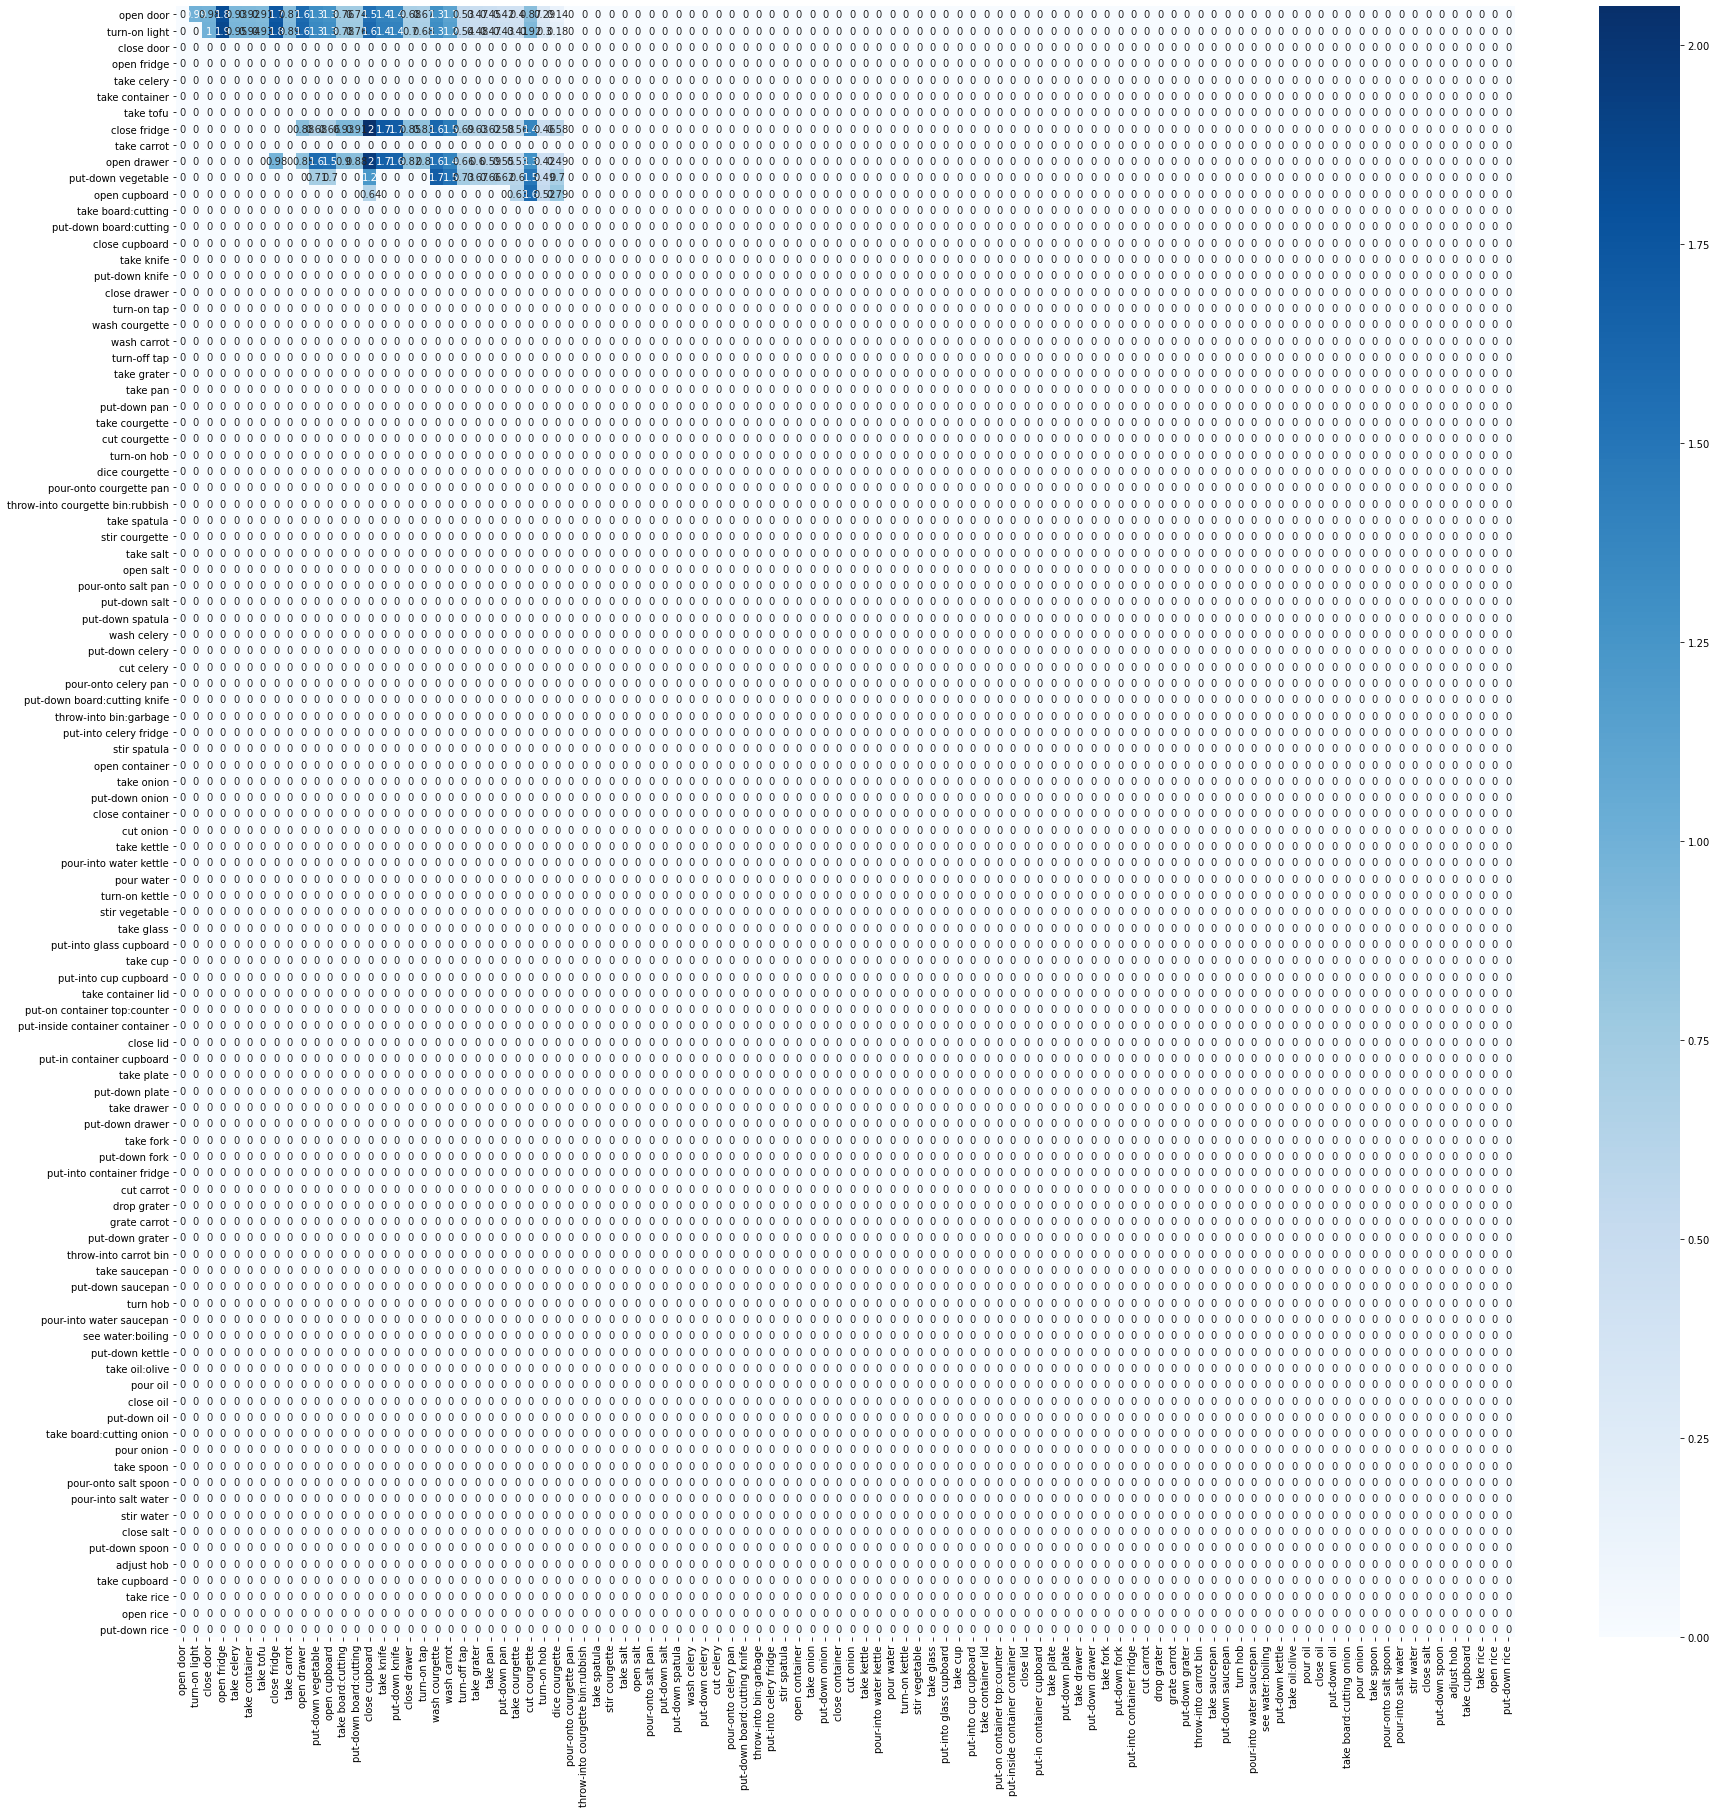

In [19]:
# Visualize causality matrix
import seaborn as sns
import matplotlib.pyplot as plt


cm_keys = list(cm.keys())
k = 100
plt.figure(figsize=[30,30])
sns.heatmap(cm_array[:k, :k], annot=True, xticklabels=cm_keys[:k], yticklabels=cm_keys[:k], cmap='Blues')
plt.show()


## Get Matrix Stats

In [ ]:
def get_causality_matrix_statistics(cm_array_l):
    '''
    Computes statistics for the causality matrix
    '''
    # Compute mean and standard deviation
    mean = np.mean(cm_array_l)
    std = np.std(cm_array_l)

    # Compute min and max
    min = np.min(cm_array_l)
    max = np.max(cm_array_l)

    # Compute median
    median = np.median(cm_array_l)

    # Compute quartiles
    q1 = np.percentile(cm_array_l, 25)
    q3 = np.percentile(cm_array_l, 75)

    # Compute range
    range = max - min

    # Compute interquartile range
    iqr = q3 - q1

    # Compute outliers
    # outliers = []
    # print(len(cm_array_l))
    # for i in np.arange(len(cm_array_l)):
    #     for j in np.arange(len(cm_array_l)):
    #         if cm_array_l[i][j] > q3 + 1.5 * iqr:
    #             outliers.append((i, j))

    return mean, std, min, max, median, q1, q3, range, iqr
    
print(get_causality_matrix_statistics(cm_array_l))

In [ ]:
# Get the top 10 values of causality matrix
top_10 = np.sort(cm_array_l.flatten())[-20:]
print(top_10)


# Get the indices of top 20 values of causality matrix
top_20_indices = np.argsort(cm_array_l.flatten())[-20:]
print(top_20_indices)

## ToDo List

- Actions that always follow another action but never precede it
- What is the the distribution of “causality scores” (i.e. the values in the cells of the matrix)? What is the highest score, the lowest score, the average? A histogram would be a helpful way to visualize this.
    - [ ] Build histogram
    - 
- How many non-zero values are there typically in a row? That is, how many downstream actions generally follow a given action? Again, a histogram showing the frequency of the count of non-zero values across all the rows would work for this
    - 99th percentile is still zero
    - [ ] typical amount of zeros in rows
- Get list of actions that have almost no follow-up actions
- Similarity between actions based on their vectors
- Histogram for non-zero cells?
- Are there actions that constrain possible futures more?